In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from unidecode import unidecode

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.linear_model import Ridge

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%load_ext autoreload
%autoreload 2

### 1. Read data

In [48]:
era_yield = (pd.read_csv("files/crop data/national_yield_detrended.csv")
             .merge(pd.read_csv("files/ERA/processed/era_basis_expansion_all_departments.csv"), on="year", how="right"))
era_yield.head(2)

,year,harvested area [ha],yield [kg/ha],yield_trend [kg/ha],yield anomaly [%],tmeansquared_buenos aires 25 de mayo_9,tmeansquared_buenos aires 25 de mayo_10,tmeansquared_buenos aires 25 de mayo_11,tmeansquared_buenos aires 9 de julio_9,tmeansquared_buenos aires 9 de julio_10,...,tmeanrain_santa fe san justo_11,tmeanrain_santa fe san lorenzo_9,tmeanrain_santa fe san lorenzo_10,tmeanrain_santa fe san lorenzo_11,tmeanrain_santa fe san martin_9,tmeanrain_santa fe san martin_10,tmeanrain_santa fe san martin_11,tmeanrain_santa fe vera_9,tmeanrain_santa fe vera_10,tmeanrain_santa fe vera_11
0,1993,4685700,2037.439151,2136.063022,-0.046171,1.420914,-0.759344,-0.111418,1.650211,-0.681814,...,-1.042311,1.285535,-2.187527,-0.110478,0.905252,-2.511513,-0.009291,-0.176854,-0.882908,-0.522672
1,1994,5070920,2185.741998,2146.803828,0.018138,-0.745486,0.285874,-0.499296,-0.713366,0.162838,...,0.355199,0.317717,0.347394,0.130898,-0.695378,-0.738003,0.676131,0.631222,-0.332272,-0.112972


### 2. Filter departments

- ERA data is available from September to November for 131 departments 
- National wheat yield forecast models are trained and validated (LOYO-CV) for each department using only its respective ERA data. 
- Departments whose national yield forecast model has a R<sup>2</sup> < 0.3 are discarded. Several threshold were tested before, with inferior performance on the final model. 

##### 2.1 Identify skillful departments

In [49]:
def obtain_skillful_departments(data, r2_threshold):
    """
    fit a national yield model for each department and returns best performances as dictionary
    params: 
        data: dataframe, with features from all municipalities
        r2_threshold: float, definition of a well-performing area
    returns:
        area_to_r2: dictionary, with keys being the municipalities and values the best model that could be fit
    """
    area_to_r2 = {}
    departments = list(set([c.split("_")[1] if c not in ['year', 'harvested area [ha]', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [%]'] else 'santa fe san cristobal' for c in data.columns]))
    for area in departments:
        best_r2 = r2_threshold
        for no_of_features in list(range(1,7)):
            X = data.loc[:, [c for c in [l for l in data.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] == area]]
            y = data["yield anomaly [%]"]

            pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_of_features)), ('estimator', Ridge())])
            loo = LeaveOneOut()
            y_pred = cross_val_predict(pipeline, X, y, cv=loo)

            current_r2 = np.round(r2_score(y, y_pred), 4)
            if current_r2 > best_r2:
                print("R2 {}; area {}; features {}".format(current_r2, area, no_of_features))
                area_to_r2[area] = current_r2
                best_r2 = current_r2
                
    selected_areas = sorted(area_to_r2, key=area_to_r2.get, reverse=True)
    return selected_areas

In [50]:
selected_areas_sorted = obtain_skillful_departments(era_yield, 0.3)
selected_areas_sorted

R2 0.3059; area buenos aires saavedra; features 1
R2 0.3245; area buenos aires coronel suarez; features 1
R2 0.3188; area buenos aires hipolito yrigoyen; features 2


['buenos aires coronel suarez',
 'buenos aires hipolito yrigoyen',
 'buenos aires saavedra']

##### 2.2 Drop ERA data from departments that are not skillful

In [51]:
era_yield_filtered = era_yield.loc[:, ["yield anomaly [%]", "year"] + [c for c in [l for l in era_yield.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] in selected_areas_sorted]]

# Order columns descending by performance of their department
# This is needed because we will drop correlated features later and only keep the first one
new_column_order = ["year", "yield anomaly [%]"]
for area in selected_areas_sorted:
    area_columns = [c for c in era_yield_filtered.columns if area in c]
    new_column_order = new_column_order + area_columns
era_yield_filtered = era_yield_filtered[new_column_order]
era_yield_filtered.head(2)

,year,yield anomaly [%],tmeansquared_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_10,tmeansquared_buenos aires coronel suarez_11,rainsquared_buenos aires coronel suarez_9,rainsquared_buenos aires coronel suarez_10,rainsquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_9,tmeanrain_buenos aires coronel suarez_10,...,tmeanrain_buenos aires hipolito yrigoyen_11,tmeansquared_buenos aires saavedra_9,tmeansquared_buenos aires saavedra_10,tmeansquared_buenos aires saavedra_11,rainsquared_buenos aires saavedra_9,rainsquared_buenos aires saavedra_10,rainsquared_buenos aires saavedra_11,tmeanrain_buenos aires saavedra_9,tmeanrain_buenos aires saavedra_10,tmeanrain_buenos aires saavedra_11
0,1993,-0.046171,-0.81915,-0.391620,0.286323,-0.640213,-0.506081,0.217259,0.507882,-0.086948,...,-2.834841,-1.029060,-0.384919,0.278988,-0.43363,-0.582685,0.432194,0.585451,-0.072264,-1.514752
1,1994,0.018138,-0.75239,-0.041853,-0.092845,-0.172277,-0.685709,0.369163,-0.031891,0.448251,...,-0.945870,-0.903234,-0.064552,-0.089106,-0.10957,-0.636763,0.194306,0.079189,0.608001,-0.938597


### 3. Train and validate national model

In [52]:
def train_and_validate_national_model(data, corr_threshold, no_features):
    """
    apply LOYO-CV on data.
    params:
        data: dataframe, contains features and targets
        corr_threshold: float, to filter correlated features before model fit
        no_features: int, number of features to train the model on
    returns (as tuple):
        features: dictionary, all features that have been selected for all folds
        rmse, current_r2, pearson_r: float, performance metrics
        y_pred, y: list, predictions and ground truth
    """
    X = data.loc[:, [c for c in data.columns if ("rain" in c) or ("tmean" in c)]]
    y = data["yield anomaly [%]"]

    # remove spatially-correlated features
    X_tmean_squared = X.loc[:, [c for c in X.columns if ("tmeansquared" in c)]]
    X_rain_squared = X.loc[:, [c for c in X.columns if ("rainsquared" in c)]]
    X_tmean_rain = X.loc[:, [c for c in X.columns if ("tmeanrain" in c)]]
    feature_sets = [X_tmean_squared, X_rain_squared, X_tmean_rain]
    to_drop =[]
    for feature_set in feature_sets:
        for month in [9, 10, 11]:
            feature_set_month = feature_set.loc[:, [c for c in feature_set.columns if (int(c.split("_")[-1]) == month)]]
            cor_matrix = feature_set_month.corr().abs().round(2)
            upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
            to_drop.append([column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)])
    to_drop = [c for k in to_drop for c in k]
    X = X.drop(to_drop, axis=1)
    
    # Leave-One-Year-Out Cross Validation
    pipeline = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_regression, k=no_features)), ('estimator', Ridge())])
    loo = LeaveOneOut()
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)
    output = cross_validate(pipeline, X, y, scoring="neg_mean_squared_error", cv=loo, return_estimator=True)
    
    # obtain features used in each fold
    features = {}
    for idx, estimator in enumerate(output['estimator']):
        selected_features = estimator.named_steps["selector"].get_feature_names_out(X.columns).tolist()
        features[idx] = selected_features
    
    # calculate metrics
    rmse = np.round(mse(y, y_pred, squared=False), 4)
    current_r2 = np.round(r2_score(y, y_pred), 4)
    pearson_r = np.round(pearsonr(y, y_pred)[0], 2)

    return (features, rmse, current_r2, pearson_r, y_pred, y)

In [53]:
best_rmse = 100
best_r2 = 0
for correlation_threshold in [.4, .5, .6,]:
    for number_of_features in [3, 4, 5, 6]:
        features, rmse, current_r2, pearson_r, y_pred, y = train_and_validate_national_model(era_yield_filtered, correlation_threshold, number_of_features)
        if rmse < best_rmse: 
            print("rmse is {}, r2 is {} for corr_threshold {} and {} features".format(rmse, current_r2, correlation_threshold, number_of_features))
            best_r2 = current_r2
            best_rmse = rmse
            feature_list = features
            best_corr = correlation_threshold
            best_f_no = number_of_features

relevant_features = list(set([item for sublist in list(feature_list.values()) for item in sublist]))
relevant_features

rmse is 0.0778, r2 is 0.6691 for corr_threshold 0.4 and 3 features


['tmeanrain_buenos aires coronel suarez_9',
 'rainsquared_buenos aires hipolito yrigoyen_9',
 'tmeanrain_buenos aires coronel suarez_11',
 'tmeansquared_buenos aires coronel suarez_11']

#### 3.1 Analyse multicollinearity of best model

Check if all folds had valid solutions, where the selected features have multicollinearity (measured as variance inflation factor) of < 3:

In [54]:
max_vif = 0
vif_list = []
for fold in feature_list:
    VIF = add_constant(era_yield_filtered[feature_list[fold]])
    result = pd.Series([variance_inflation_factor(VIF.values, i) for i in range(VIF.shape[1])], index=VIF.columns)
    vif_result = np.round(result.loc[~result.index.str.contains("const")].max(), 2)
    if vif_result > max_vif:
        vif_list.append(vif_result)
print(list(set(vif_list)))

[1.94, 1.05]


### 4. Visualize estimates

#### 4.1 Read shapefiles to plot map

In [55]:
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(list(set([c.split("_")[1] for c in relevant_features]))), ["name", "geometry"]].reset_index(drop=True)

#### 4.2 Create plot

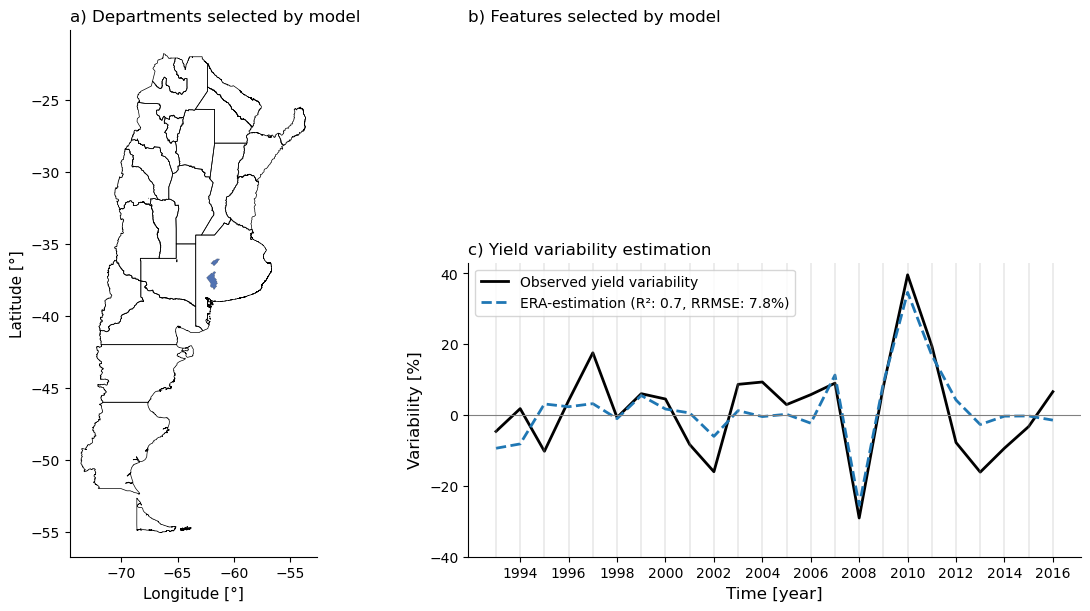

In [66]:
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(11, 6), layout="constrained", width_ratios=[0.4, 0.6], height_ratios=[0.4, 0.6])

# Figure a) Study region
gdf_adm2.plot(ax=axd["left"], color="#5273B2", edgecolor="black", linewidth=.1)
gdf_adm1.plot(ax=axd["left"], color="#FF000000", edgecolor="black", linewidth=.5)
axd['left'].set_title("a) Departments selected by model", loc="left", size=12);
axd['left'].set_ylabel("Latitude [°]", size=11);
axd['left'].set_xlabel("Longitude [°]", size=11);
axd['left'].spines[['right', 'top']].set_visible(False)

# Figure b) manually added in Figma as table
loc2 = "upper right"
axd[loc2].set_title("b) Features selected by model", loc="left");
axd[loc2].axis("off")

# Figure c) Observed and predicted yield anomaly by year
loc3 = "lower right"
(features, rmse, current_r2, pearson_r, y_pred, y) = train_and_validate_national_model(era_yield_filtered, best_corr, best_f_no)
axd[loc3].plot(era_yield_filtered["year"], 100*y, color="black", label="Observed yield variability", linewidth=2);
axd[loc3].plot(era_yield_filtered["year"], 100*y_pred, linestyle="dashed", label="ERA-estimation (R\u00b2: {}, RRMSE: {}%)".format(round(best_r2, 1), round(100*best_rmse, 1)), linewidth=2);
axd[loc3].set_ylabel("Variability [%]", size=12)
axd[loc3].set_title("c) Yield variability estimation", loc="left", size=12);
axd[loc3].set_xlabel("Time [year]", size=12)
axd[loc3].set_xticks(list(range(1994, 2017, 2)))
axd[loc3].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd[loc3].set_yticks([40, 20, 0, -20, -40])
xcoords = list(range(1993, 2016, 2))
for xc in xcoords:
    axd[loc3].axvline(x=xc, linewidth=.3, color="#A8A8A8")
axd[loc3].spines[['right', 'top']].set_visible(False)
axd[loc3].axhline(0, 0, color="grey", linewidth=.8)
axd[loc3].legend(loc="upper left");

plt.savefig("files/figures/figure2.svg")
plt.show();

### 5. Drop unselected features and export dataset

In [57]:
era_yield_filtered_features = era_yield_filtered.assign(model="ERA", init_month=12).set_index(["model", "year", "init_month", "yield anomaly [%]"])[relevant_features].reset_index(drop=False)

era_yield_filtered_features.to_csv("files/ERA/processed/era_final_features.csv", index=False)